In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz

from sklearn.preprocessing import StandardScaler

# EDA

In [3]:
# load datasets
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

In [ ]:
# display basic info
print("=== Dataset Information ===")
white_wine.info()

# display summary statistics
print("\n=== Summary Statistics ===")
print(white_wine.describe())

# check for missing values
print("\n=== Missing Values ===")
print(white_wine.isnull().sum())

### Univariate Analysis

In [ ]:
""" features - distribution plots """
plt.figure(figsize=(15, 20))

for i, column in enumerate(white_wine.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(white_wine[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

plt.show()

In [ ]:
""" features - box plots """
plt.figure(figsize=(15, 20))

for i, column in enumerate(white_wine.columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=white_wine[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()

plt.show()

In [ ]:
""" features - correlation matrix """
corr_matrix = white_wine.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Wine Features')
plt.show()

### Bivariate Analysis

In [ ]:
""" two features - scatter plots """
# alcohol vs quality
plt.figure(figsize=(10, 6))
sns.scatterplot(x='alcohol', y='quality', data=white_wine, alpha=0.5, color='purple')
plt.title('Alcohol vs Quality')
plt.show()

# density vs residual sugar
plt.figure(figsize=(10, 6))
sns.scatterplot(x='residual sugar', y='density', data=white_wine, alpha=0.5, color='orange')
plt.title('Residual Sugar vs Density')
plt.show()

In [ ]:
# select a subset of features for clarity
subset = white_wine[['fixed acidity', 'volatile acidity', 'citric acid', 'alcohol', 'quality']]
sns.pairplot(subset, hue='quality', palette='viridis')
plt.suptitle('Pairwise Relationships of Selected Features', y=1.02)
plt.show()

# Normalization

In [14]:
X = white_wine.drop('quality', axis=1)

y = white_wine['quality']

In [15]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


In [16]:
y.head()

0    6
1    6
2    6
3    6
4    6
Name: quality, dtype: int64

## Range Scaling

In [17]:
means = np.array(X.mean())
mins = np.array(X.min())
maxs = np.array(X.max())  

X_range =  X

for index, row in X_range.iterrows():
    X_range.loc[index] = (row - means) / (maxs - mins)


In [18]:
X_range.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.013963,-0.008080,0.015547,0.219457,-0.002292,0.033770,0.073409,0.134425,-0.171151,-0.046334,-0.276495
1,-0.053345,0.021332,0.003499,-0.073488,0.009578,-0.074244,-0.014758,-0.000528,0.101576,0.000178,-0.163591
2,0.119732,0.001724,0.039644,0.007800,0.012545,-0.018495,-0.095964,0.020679,0.065212,-0.057961,-0.066817
3,0.033193,-0.047295,-0.008549,0.032340,0.036284,0.040738,0.110532,0.030319,0.001576,-0.104473,-0.099075
4,0.033193,-0.047295,-0.008549,0.032340,0.036284,0.040738,0.110532,0.030319,0.001576,-0.104473,-0.099075


## Standardization

In [19]:
zscore_scaler = StandardScaler()
zscore_array = zscore_scaler.fit_transform(X)
X_zscore = pd.DataFrame(zscore_array, columns=X.columns)

In [20]:
X_zscore.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.172097,-0.081770,0.213280,2.821349,-0.035355,0.569932,0.744565,2.331512,-1.246921,-0.349184,-1.393152
1,-0.657501,0.215896,0.048001,-0.944765,0.147747,-1.253019,-0.149685,-0.009154,0.740029,0.001342,-0.824276
2,1.475751,0.017452,0.543838,0.100282,0.193523,-0.312141,-0.973336,0.358665,0.475102,-0.436816,-0.336667
3,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203
4,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203


# Fuzzy c-Means (FCM)

In [120]:
c_min, c_max = 2, 10
cost_values = []


# Iterar sobre diferentes números de clusters
for c in range(c_min, c_max):
    # Aplicar Fuzzy C-Means
    cntr, u, _, _, jm, _, _ = fuzz.cluster.cmeans(
        X_range, c, m=2, error=0.005, maxiter=1000, init=None
    )
    print(min(jm), jm[-1])
    cost_values.append(min(jm))  # Armazenar o custo final

# Converter os custos em um DataFrame para melhor visualização
#cost_df = pd.DataFrame({'Número de Clusters (c)': range(c_min, c_max), 'Custo Final': cost_values})

# Exibir os primeiros valores (ou todos, se necessário)
#print(cost_df)
    

278.61717481099026 278.61717481099026
160.1392526746504 160.1392526746504
110.43360987960462 110.43360987960462
83.88767385126998 83.88767385126998
57.36544489340619 57.36544489340619
46.631731231234205 46.631731231234205
48.49783236418935 48.49783236418935
33.91621519359835 33.91621519359835


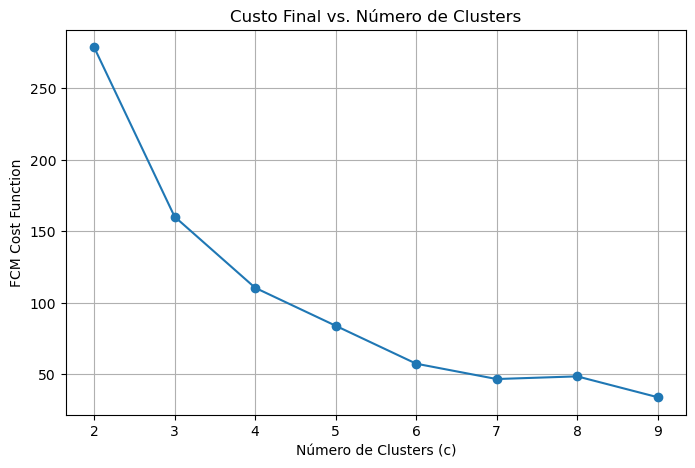

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(c_min, c_max), cost_values, marker='o', linestyle='-')
plt.xlabel("Número de Clusters (c)")
plt.ylabel("FCM Cost Function")
plt.title("Custo Final vs. Número de Clusters")
plt.grid()
plt.show()


### Find best C
for range and z-score

In [61]:
def best_c_clusters(X_range, c_min=2, c_max=8, num_seeds=50):
    best_c_count = {c: 0 for c in range(c_min, c_max)}  # Contador para cada número de clusters
    
    # Gerar várias seeds
    for seed in range(num_seeds):
        cost_values = []
        
        # Iterar sobre diferentes números de clusters entre c_min e c_max
        for c in range(c_min, c_max):
            # Aplicar Fuzzy C-Means
            cntr, u, _, _, cost, _, _ = fuzz.cluster.cmeans(
                X_range, c, m=2, error=0.005, maxiter=1000, init=None
            )
            
            cost_values.append(cost[-1])  # Armazenar o custo final
        
        # Encontrar o número de clusters com o menor custo entre 3 e 8
        best_c = np.argmin(cost_values)
        
        # Verificar se o best_c está dentro do intervalo permitido (3 a 8)
        if c_min <= best_c <= c_max+1:
            best_c_count[best_c] += 1
        
    for c in range(c_min, c_max+1):
        print(f"c = {c}: {best_c_count[c]} vezes")

In [62]:
np.mean(cost[-1])

35.986368239397414

In [63]:
def show_best_c_clusters(X, c_min=2, c_max=8, n_seeds=50):
    
    best_c_counts = {c: 0 for c in range(c_min, c_max + 1)} # initialize dictionary with c=3 to c=8 with 0s

    for seed in range(n_seeds):
        print(f"Seed {seed+1} / ", n_seeds, " ...")   # process displayer
        np.random.seed(seed)
        mean_costs = []

        for c in range(c_min, c_max + 1):
            cntr, u, _, _, cost, _, _ = fuzz.cluster.cmeans(
                X, c, m=2, error=0.005, maxiter=1000, init=None
            )
            mean_costs.append(np.mean(cost[-1]))
        
        # find best C for this current seed (with lowest mean cost)
        best_c = np.argmin(mean_costs) + c_min
        
        if c_min <= best_c <= c_max:
            best_c_counts[best_c] += 1 # increse count

    for c in range(c_min, c_max+1): # show results c by c
        print(c, ": ", best_c_counts[c])

In [64]:
show_best_c_clusters(X_range)

Seed 1 /  50  ...
Seed 2 /  50  ...
Seed 3 /  50  ...
Seed 4 /  50  ...
Seed 5 /  50  ...
Seed 6 /  50  ...
Seed 7 /  50  ...
Seed 8 /  50  ...
Seed 9 /  50  ...
Seed 10 /  50  ...
Seed 11 /  50  ...
Seed 12 /  50  ...
Seed 13 /  50  ...
Seed 14 /  50  ...
Seed 15 /  50  ...
Seed 16 /  50  ...
Seed 17 /  50  ...
Seed 18 /  50  ...
Seed 19 /  50  ...
Seed 20 /  50  ...
Seed 21 /  50  ...
Seed 22 /  50  ...
Seed 23 /  50  ...
Seed 24 /  50  ...
Seed 25 /  50  ...
Seed 26 /  50  ...
Seed 27 /  50  ...
Seed 28 /  50  ...
Seed 29 /  50  ...
Seed 30 /  50  ...
Seed 31 /  50  ...
Seed 32 /  50  ...
Seed 33 /  50  ...
Seed 34 /  50  ...
Seed 35 /  50  ...
Seed 36 /  50  ...
Seed 37 /  50  ...
Seed 38 /  50  ...
Seed 39 /  50  ...
Seed 40 /  50  ...
Seed 41 /  50  ...
Seed 42 /  50  ...
Seed 43 /  50  ...
Seed 44 /  50  ...
Seed 45 /  50  ...
Seed 46 /  50  ...
Seed 47 /  50  ...
Seed 48 /  50  ...
Seed 49 /  50  ...
Seed 50 /  50  ...
2 :  0
3 :  0
4 :  0
5 :  0
6 :  0
7 :  5
8 :  45


In [65]:
show_best_c_clusters(X_zscore)

Seed 1 /  50  ...
Seed 2 /  50  ...
Seed 3 /  50  ...
Seed 4 /  50  ...
Seed 5 /  50  ...
Seed 6 /  50  ...
Seed 7 /  50  ...
Seed 8 /  50  ...
Seed 9 /  50  ...
Seed 10 /  50  ...
Seed 11 /  50  ...
Seed 12 /  50  ...
Seed 13 /  50  ...
Seed 14 /  50  ...
Seed 15 /  50  ...
Seed 16 /  50  ...
Seed 17 /  50  ...
Seed 18 /  50  ...
Seed 19 /  50  ...
Seed 20 /  50  ...
Seed 21 /  50  ...
Seed 22 /  50  ...
Seed 23 /  50  ...
Seed 24 /  50  ...
Seed 25 /  50  ...
Seed 26 /  50  ...
Seed 27 /  50  ...
Seed 28 /  50  ...
Seed 29 /  50  ...
Seed 30 /  50  ...
Seed 31 /  50  ...
Seed 32 /  50  ...
Seed 33 /  50  ...
Seed 34 /  50  ...
Seed 35 /  50  ...
Seed 36 /  50  ...
Seed 37 /  50  ...
Seed 38 /  50  ...
Seed 39 /  50  ...
Seed 40 /  50  ...
Seed 41 /  50  ...
Seed 42 /  50  ...
Seed 43 /  50  ...
Seed 44 /  50  ...
Seed 45 /  50  ...
Seed 46 /  50  ...
Seed 47 /  50  ...
Seed 48 /  50  ...
Seed 49 /  50  ...
Seed 50 /  50  ...
2 :  0
3 :  0
4 :  0
5 :  0
6 :  0
7 :  4
8 :  46


## Anomalous Pattern (IAP) clustering algorithm

In [28]:
## Anomalous Pattern Algorithm

def center_(x, cluster):
    """ 
    Calculates the centroid of the cluster.
    """
    mm = x.shape[1]
    centroidC = []
    
    for j in range(mm):
        zz = x[:, j]
        zc = [zz[i] for i in cluster]
        centroidC.append(np.mean(zc))
    return centroidC

def distNorm(x, remains, ranges, p):
    """ 
    Finds the normalized distances of data points in 'remains' to reference point 'p'.  
    """
    mm = x.shape[1]
    rr = len(remains)    
    z = x[remains, :]
    az = np.tile(np.array(p), (rr, 1))     
    rz = np.tile(np.array(ranges), (rr, 1))
    dz = (z - az) / rz
    dz = np.array(dz)
    ddz = dz * dz
    if mm > 1:
        di = sum(ddz.T)
    else:
        di = ddz.T
    return di

def separCluster(x0, remains, ranges, a, b):
    """  
    Builds a cluster by splitting the points around reference point 'a' from those around 'b'.  
    """
    dista = distNorm(x0, remains, ranges, a)
    distb = distNorm(x0, remains, ranges, b)
    clus = np.where(dista < distb)[0]
    return [remains[i] for i in clus]

def anomalousPattern(x, remains, ranges, centroid, me):
    """  
    Builds one anomalous cluster based on the Separate/Conquer method.  
    """
    key = 1
    while key == 1:
        cluster = separCluster(x, remains, ranges, centroid, me)
        if len(cluster) != 0:
            newcenter = center_(x, cluster)
        if len([i for i, j in zip(centroid, newcenter) if i == j]) != len(centroid):
            centroid = newcenter
        else:
            key = 0
    return (cluster, centroid)

def dist(x, remains, ranges, p):
    """ 
    Calculates the normalized distances of data points in 'remains' to reference point 'p'.   
    """
    mm = x.shape[1]      
    rr = len(remains)    
    distan = np.zeros((rr,1))    
    for j in range(mm):
        z = x[:, j].reshape((-1,1))
        zz = z[remains]
        y = (zz - p[j]) / ranges[j]
        yy = y * y
        distan = distan + yy
    return distan

In [29]:
##### ****** Main body for the Iterative Anomalous Cluster Algorithm  *****

# Normalization FLAG (mantido, pode ser ajustado)
normalization = 0

# Threshold de cardinalidade do cluster
threshold = 25

x = X_zscore.values.astype(np.float32)

nn = x.shape[0]
mm = x.shape[1]

# grand means
me = []
# maximum value
mmax = []
# minimum value
mmin = []
# ranges
ranges = []
# "anomalous cluster" ancl is the data structure to keep everything together
ancl = []


for j in range(mm): # for each feature
    z = x[:, j]     # data column vector j-th feature
    me.append(np.mean(z))
    mmax.append(np.max(z))
    mmin.append(np.min(z))
    if normalization:
        ranges.append(1)
    else:
        ranges.append(mmax[j] - mmin[j])
    if ranges[j] == 0:
        print("Variable num {} is contant!".format(j))
        ranges[j] = 1
    
sy = np.divide((x - me), ranges)
sY = np.array(sy)
d = np.sum(sY * sY)   # total data scatter of normalized data

In [30]:
remains = list(range(nn))  
ancl = []  
numberC = 0  

while len(remains) != 0:
    distance = dist(x, remains, ranges, me)
    index = remains[np.argmax(distance)]
    centroid = x[index, :]
    numberC += 1
    
    (cluster, centroid) = anomalousPattern(x, remains, ranges, centroid, me)
    
    censtand = (np.asarray(centroid) - me) / np.asarray(ranges)   
    dD = np.sum((censtand * censtand.T * len(cluster) * 100) / d)  

    remains = np.setdiff1d(remains, cluster) 
    ancl.append((cluster, censtand, dD))  

# **Evita o erro de conversão**
clusters_list = [c[0] for c in ancl]   # Lista de clusters
centroids_list = np.array([c[1] for c in ancl])  # Matriz de centróides
dD_list = np.array([c[2] for c in ancl])  # Matriz de dD

## *** Substituir np.asarray(ancl) por listas separadas ***
numberC = len(clusters_list)  # Atualiza número de clusters

b = 3
ll = [len(cluster) for cluster in clusters_list]  # Lista com tamanhos dos clusters

rl = [i for i in ll if i >= threshold]  # Clusters que atendem ao threshold
cent = []

if len(rl) == 0:
    print('Too great a threshold!!!')
else:
    num_cents = 0
    for ik in range(numberC):
        if len(clusters_list[ik]) >= threshold:
            cent.append(centroids_list[ik])
            num_cents += 1

cent = np.asarray(cent)

In [31]:
zscor_data = np.column_stack((X_zscore, y))  # Junta `y` como última coluna

# make pca data the same for now...
zscor_data_pca = zscor_data

In [32]:
zscor_data_pca[0]

array([ 0.17209696, -0.0817699 ,  0.2132802 ,  2.82134917, -0.035355  ,
        0.56993158,  0.74456503,  2.33151201, -1.24692128, -0.34918426,
       -1.39315246,  6.        ])

In [33]:
## Should be adapted:
DECIMAL_PLACES=3
cent = cent.reshape((len(cent), len(zscor_data_pca.columns) - 1)) # FAZER JÁ PCA?????
print("Initial prototypes: \n", np.round(cent, DECIMAL_PLACES))
init_partition = np.zeros((zscor_data_pca.shape[0], len(cent)))

for index, d in enumerate(zscor_data):
   dists = [np.linalg.norm(d - c) for c in cent]
   assign = dists.index(np.min(dists))
   init_partition[index, assign] = 1

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

# All data - white + red wine

In [ ]:
# ...